In [1]:
import os
import cv2
import joblib
import numpy as np
from skimage.feature import hog
import pywt
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score

In [2]:
#load the model and the feature selector
svm = joblib.load('saved_model.pkl')
chi2_selector = joblib.load('feature_selector.pkl')

In [3]:
def load_images(base_folder, limit=None):
    images = []
    image_paths = []
    count = 0
    for root, _, files in os.walk(base_folder):
        for file in files:
            if file.endswith('.ppm'):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:  
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    images.append(img)
                    image_paths.append(img_path)
                    count += 1
                    if limit is not None and count >= limit:  
                        return images, image_paths
    return images, image_paths


In [4]:
#read the ground truth file (parse it)
def parse_ground_truth(gt_file):
    gt_data = []
    with open(gt_file, 'r') as f:
        for line in f:
            parts = line.strip().split(';')
            filename = parts[0]
            x1, y1, x2, y2 = map(int, parts[1:5])
            class_id = int(parts[5])
            gt_data.append((filename, x1, y1, x2, y2, class_id))
    return gt_data

In [5]:
#preprocess the image
def preprocess_image(image, size=(32, 32)):
    image = cv2.resize(image, size)
    image = image / 255.0 
    return image

#extract features of the image
def extract_features(image):
    hog_features = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), channel_axis=-1)
    coeffs = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs
    wavelet_features = np.hstack((cA.flatten(), cH.flatten(), cV.flatten(), cD.flatten()))
    combined_features = np.hstack((hog_features, wavelet_features))
    return combined_features

In [6]:
def classify(image_folder, gt_file, limit=None):
    #load imgs and ground truth file
    images, image_paths = load_images(image_folder, limit) 
    gt_data = parse_ground_truth(gt_file)
    
    y_true = []
    y_pred = []
    results = []
    
    for img, path in zip(images, image_paths):
        filename = os.path.basename(path)
        
        #find ground truth data for the current img
        for gt in gt_data:
            if gt[0] == filename:
                x1, y1, x2, y2 = gt[1:5]  #coordinates
                class_id = gt[5] #class id
                
                #extract ROI
                roi = img[y1:y2, x1:x2]
                
                
                if roi.size == 0:
                    continue
                
                
                preprocessed_roi = preprocess_image(roi)
                features = extract_features(preprocessed_roi)
                features = np.maximum(features, 0) 
                features = chi2_selector.transform(features.reshape(1, -1))  
                
                
                prediction = svm.predict(features)
                
                y_true.append(class_id)
                y_pred.append(prediction[0])
                results.append({
                    'filename': filename,
                    'class_id': class_id,
                    'predicted_class': prediction[0],
                    'image': img,
                    'bounding_box': (x1, y1, x2, y2)
                })
                

                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                break

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    for result in results[:10]:  # Display first 5 images as an example
        img_bgr = cv2.cvtColor(result['image'], cv2.COLOR_RGB2BGR)
        plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        plt.title(f"Filename: {result['filename']}\nReal Class: {result['class_id']}, Predicted: {result['predicted_class']}")
        plt.axis('off')
        plt.show()

In [7]:
gtsdb_image_folder = r'C:\Users\aakaash\OneDrive\Desktop\QMUL\Project\PROJECT\archive\FullIJCNN2013\FullIJCNN2013'
gt_file = r'C:\Users\aakaash\OneDrive\Desktop\QMUL\Project\PROJECT\archive\FullIJCNN2013\FullIJCNN2013\gt.txt'

Accuracy: 69.64%


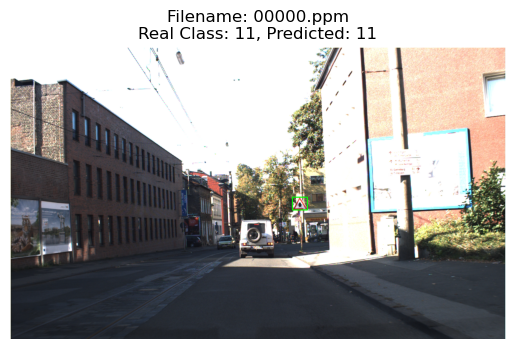

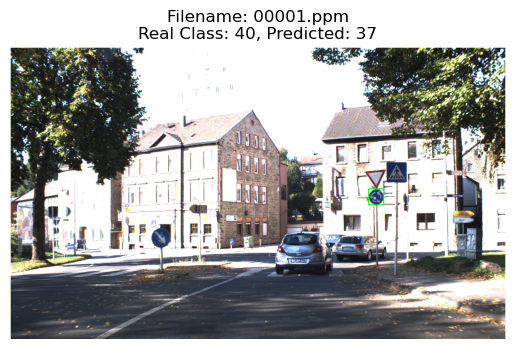

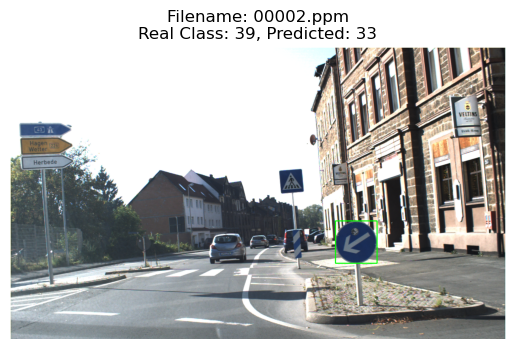

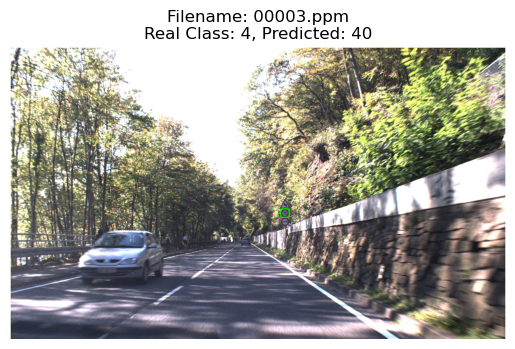

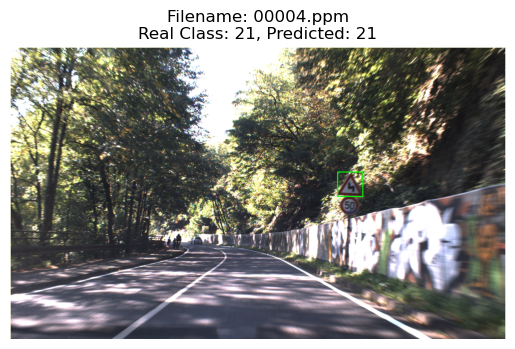

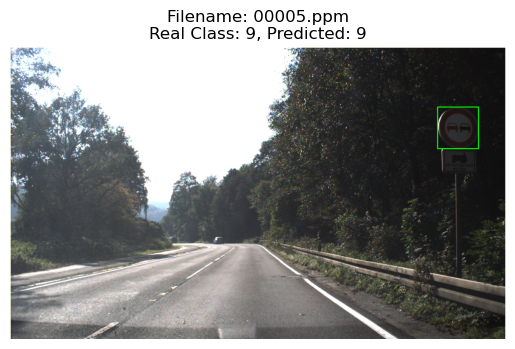

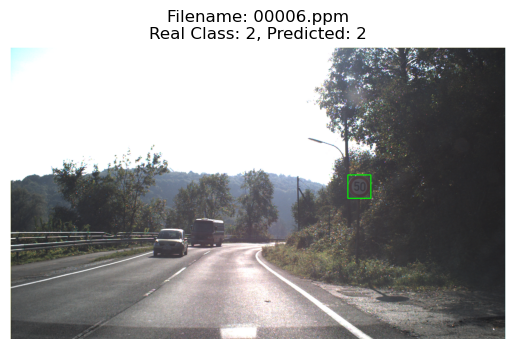

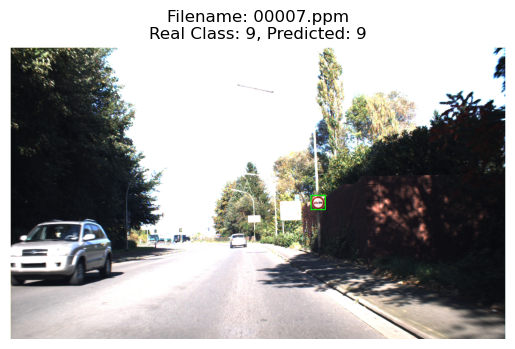

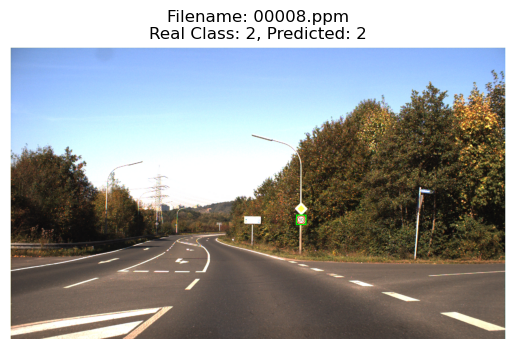

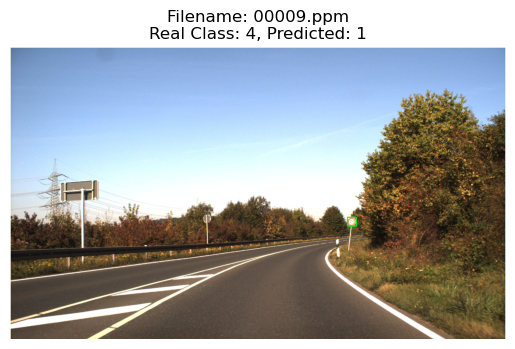

In [8]:
classify(gtsdb_image_folder, gt_file)  